<a href="https://colab.research.google.com/github/sayali1004/Supply_Chain/blob/main/Predictive_Modeling_of_Late_Delivery_Risk_in_Supply_Chain_Logistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
from scipy.stats import f_oneway


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV


In [ ]:
file_path = '/content/DataCoSupplyChainDataset.csv'
df = pd.read_csv(file_path,encoding='ISO-8859-1')

In [ ]:
df.shape

(180519, 53)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [ ]:
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


# Pre-Processing

In [ ]:
# find missing values in each column
df.isnull().mean() * 100 # this calculated the percentage of null values within the column

# drop 'Product 'Description' column and 'Order Zipcode'
# since they contain 100 and 86 percent empty values respectively
df = df.drop(columns=['Product Description','Order Zipcode'], axis=1)

# interesting results from running: df.isnull().mean() * 100
# Product Description 100.0
# Order Zipcode	86.239676
# Customer Lname	0.004432
# Customer Zipcode 0.001662

In [ ]:
# filter for where Order country is United States (EE.UU)
#  and where customer is in the United States
df['Order Country'].unique()

# change EE.UU (Estados Unidos) to USA
df.loc[df['Order Country'] == 'Estados Unidos','Order Country'] = 'USA'
df.loc[df['Customer Country'] == 'EE. UU.', 'Customer Country'] = 'USA'

df = df[(df['Order Country'] == 'USA') & (df['Customer Country'] == 'USA')]

# validate
print(df['Order Country'].unique(), df['Customer Country'].unique())

df.shape

['USA'] ['USA']


(15442, 51)

In [ ]:
# Standardize column names
df.columns = df.columns.str.lower().str.replace(' ','_')
df.columns

Index(['type', 'days_for_shipping_(real)', 'days_for_shipment_(scheduled)',
       'benefit_per_order', 'sales_per_customer', 'delivery_status',
       'late_delivery_risk', 'category_id', 'category_name', 'customer_city',
       'customer_country', 'customer_email', 'customer_fname', 'customer_id',
       'customer_lname', 'customer_password', 'customer_segment',
       'customer_state', 'customer_street', 'customer_zipcode',
       'department_id', 'department_name', 'latitude', 'longitude', 'market',
       'order_city', 'order_country', 'order_customer_id',
       'order_date_(dateorders)', 'order_id', 'order_item_cardprod_id',
       'order_item_discount', 'order_item_discount_rate', 'order_item_id',
       'order_item_product_price', 'order_item_profit_ratio',
       'order_item_quantity', 'sales', 'order_item_total',
       'order_profit_per_order', 'order_region', 'order_state', 'order_status',
       'product_card_id', 'product_category_id', 'product_image',
       'product_na

In [ ]:
# check for duplicate rows
df[df.duplicated()]

,type,days_for_shipping_(real),days_for_shipment_(scheduled),benefit_per_order,sales_per_customer,delivery_status,late_delivery_risk,category_id,category_name,customer_city,...,order_state,order_status,product_card_id,product_category_id,product_image,product_name,product_price,product_status,shipping_date_(dateorders),shipping_mode


In [ ]:
# fill missing customer lastnames with "Unknown"
df['customer_lname'].isnull().sum()

df['customer_lname'] = df['customer_lname'].fillna('Unknown')

# drop rows where customer_zipcode is null
df = df[~df['customer_zipcode'].isnull()]


In [ ]:
# convert (dateorders)  to datetime
df['shipping_date_(dateorders)'] = pd.to_datetime(df['shipping_date_(dateorders)'])
df['order_date_(dateorders)'] = pd.to_datetime(df['order_date_(dateorders)'])

In [ ]:
# save a copy of the dataset before dropping columns
df_raw = df.copy()

In [ ]:
# drop unimportant columns after measuring variance/cardinality
df.nunique()
df.nunique()/df.shape[0] * 100 # percent variance

# Columns to drop because they have too high or too little variance
columns_to_drop = [
    'order_item_id', 'order_id', 'order_customer_id', 'customer_email',
    'customer_fname', 'customer_lname', 'customer_password', 'product_image',
    'customer_street','market','product_status',
]

# Drop the columns
df = df.drop(columns=columns_to_drop, axis=1)

### Feature Engineering

In [ ]:
# feature engineering
df['shipping_delay'] = df['days_for_shipping_(real)'] - df['days_for_shipment_(scheduled)']
df['days_before_order_received'] = (df['shipping_date_(dateorders)'] - df['order_date_(dateorders)']).dt.days

# Order date features
df['order_month'] = df['order_date_(dateorders)'].dt.month
df['order_dayofweek'] = df['order_date_(dateorders)'].dt.dayofweek # 0=Monday
df['order_year'] = df['order_date_(dateorders)'].dt.year.astype(int)
df['is_weekend_order'] = df.apply(lambda x: 1 if x['order_dayofweek'] >=5 else 0, axis=1)

# shipping date features
df['shipping_dayofweek'] = df['shipping_date_(dateorders)'].dt.dayofweek  # 0=Monday, 6=Sunday
df['shipping_month'] = df['shipping_date_(dateorders)'].dt.month


# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15442 entries, 183 to 177551
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   type                           15442 non-null  object        
 1   days_for_shipping_(real)       15442 non-null  int64         
 2   days_for_shipment_(scheduled)  15442 non-null  int64         
 3   benefit_per_order              15442 non-null  float64       
 4   sales_per_customer             15442 non-null  float64       
 5   delivery_status                15442 non-null  object        
 6   late_delivery_risk             15442 non-null  int64         
 7   category_id                    15442 non-null  int64         
 8   category_name                  15442 non-null  object        
 9   customer_city                  15442 non-null  object        
 10  customer_country               15442 non-null  object        
 11  customer_id      

In [ ]:
# descriptive statistics of numerical cols
df.describe().T

,count,mean,min,25%,50%,75%,max,std
days_for_shipping_(real),15442.0,3.496179,0.0,2.0,3.0,5.0,6.0,1.617618
days_for_shipment_(scheduled),15442.0,2.91549,0.0,2.0,4.0,4.0,4.0,1.375131
benefit_per_order,15442.0,21.342529,-1336.369995,7.27,30.799999,63.112499,240.080002,96.081787
sales_per_customer,15442.0,175.817705,9.09,103.989998,159.940002,239.979996,499.950012,100.442584
late_delivery_risk,15442.0,0.552454,0.0,0.0,1.0,1.0,1.0,0.497257
category_id,15442.0,30.122717,3.0,18.0,29.0,45.0,48.0,13.634806
customer_id,15442.0,6172.190714,2.0,3054.25,6101.0,9310.5,12429.0,3597.838156
customer_zipcode,15442.0,58208.76266,1201.0,29223.0,60647.0,90262.0,99205.0,32018.007818
department_id,15442.0,5.34717,2.0,4.0,5.0,7.0,7.0,1.471351
latitude,15442.0,36.838062,18.248312,33.811123,37.344204,40.746761,48.781933,4.893011


In [ ]:
df.describe(include='object').T

,count,unique,top,freq
type,15442,4,DEBIT,5983
delivery_status,15442,4,Late delivery,8531
category_name,15442,24,Cleats,2171
customer_city,15442,534,Los Angeles,553
customer_country,15442,1,USA,15442
customer_segment,15442,3,Consumer,8099
customer_state,15442,43,CA,4040
department_name,15442,6,Fan Shop,5901
order_city,15442,472,New York City,1373
order_country,15442,1,USA,15442


Text(0.5, 0, 'shipping delay (days)')

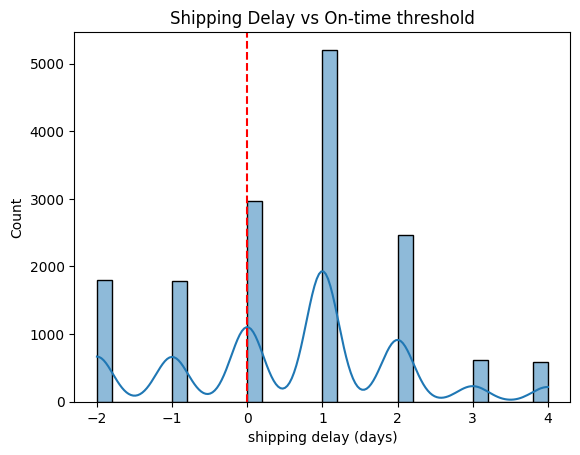

In [ ]:
sns.histplot(data=df, x='shipping_delay', bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')  # On-time threshold
plt.title("Shipping Delay vs On-time threshold")
plt.xlabel('shipping delay (days)')

In [ ]:
plt.savefig('Shipping Delay vs On-time threshold.png')
plt.show()

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Order Status Distribution')

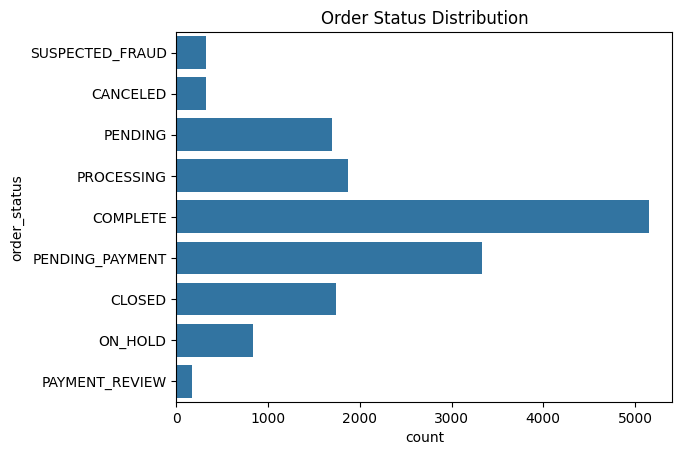

In [ ]:
sns.countplot(data=df, y='order_status')
plt.title('Order Status Distribution')

Text(0.5, 1.0, 'Delivery Status Distribution')

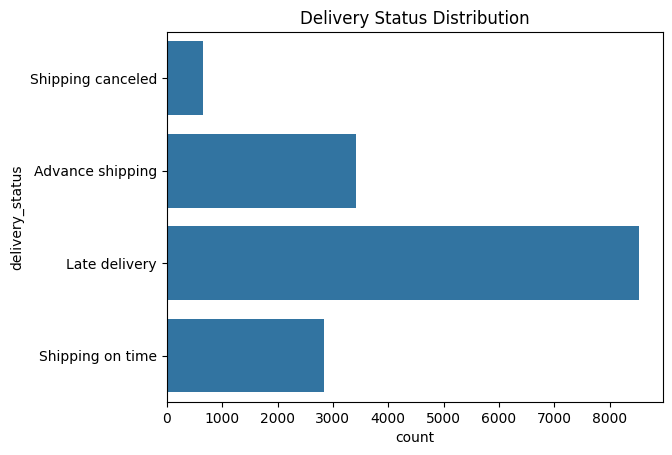

In [ ]:
sns.countplot(data=df,y='delivery_status')
plt.title('Delivery Status Distribution')

Text(0.5, 1.0, 'Shipping Mode Usage by Orders')

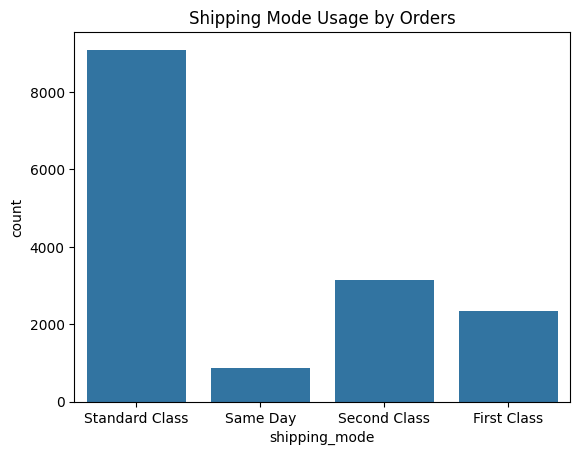

In [ ]:
sns.countplot(data=df,x='shipping_mode')
plt.title('Shipping Mode Usage by Orders')

Text(0.5, 0, 'Customer Type')

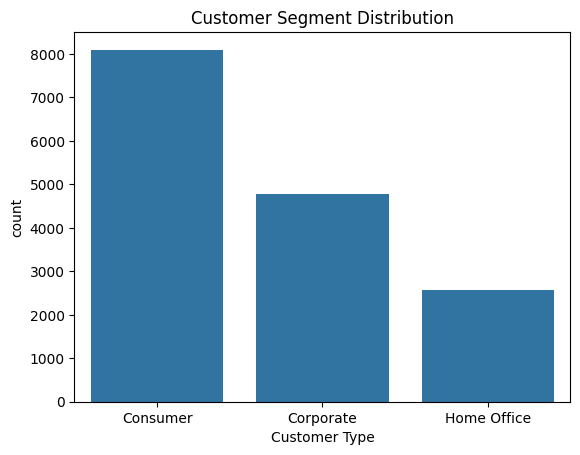

In [ ]:
sns.countplot(data=df,x='customer_segment')
plt.title("Customer Segment Distribution")
plt.xlabel("Customer Type")

Text(0.5, 1.0, 'Order Distribution by Day of Week')

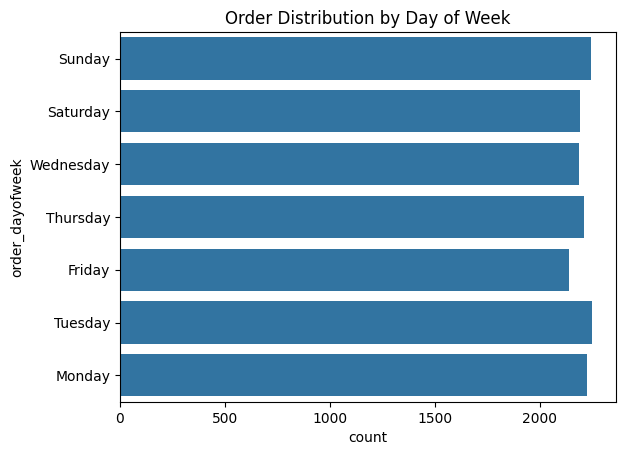

In [ ]:
day_names = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
weekdays = df['order_dayofweek'].map(day_names)
sns.countplot(y= weekdays)
plt.title('Order Distribution by Day of Week')

In [ ]:
# Orders by day of week (Sunday and Tuesday are very popular)
sales_by_order = df.groupby(['order_dayofweek'])['sales'].sum()
sales_by_order.index = sales_by_order.index.map(day_names)
sales_order = sales_by_order.sort_values(ascending=False)
sales_order.apply(lambda x: f'${x:,.2f}')

# styled dataFrame to highlight top 2 days
styled_sales = sales_order.to_frame(name='sales').style\
    .apply(lambda s: ['color: yellow' if v in s.nlargest(2).values else '' for v in s], subset=['sales'])\
    .format({'sales': '${:,.2f}'})

styled_sales

,sales
order_dayofweek,
Sunday,"$442,683.55"
Tuesday,"$438,554.83"
Saturday,"$436,197.51"
Monday,"$434,682.35"
Thursday,"$431,278.07"
Wednesday,"$421,834.45"
Friday,"$414,471.10"


In [ ]:
# how many intems where shipped each day of the week
shipments = df.groupby('shipping_dayofweek')['order_item_quantity'].sum()
shipments.index  = shipments.index.map(day_names)
shipments.sort_values(ascending=False)

,order_item_quantity
shipping_dayofweek,
Thursday,5112
Saturday,4965
Monday,4909
Wednesday,4801
Sunday,4702
Friday,4684
Tuesday,4640


## Is the observed difference in sales by day of week statistically significant ?

In [ ]:
# peforming a one-way anova

# Create separate lists of sales for each day
# this get the day sales for each day of the week from 0 to 6 (7 days)
day_ofweek_groups = [df[df['order_dayofweek'] == i]['sales'].values for i in range(7)]


# run the one-way anova
f_stat, p_val = f_oneway(*day_ofweek_groups) # used the * to unpack the arrays within day_ofweek_groups

print(f"F-statistic:, {f_stat:.4f}") #0.8050
print(f"p-value:, {p_val:.4f}") #0.5658

# this implies that the observed differences could be due to random chance rather than a true effect.

F-statistic:, 0.7724
p-value:, 0.5915


In [ ]:
# what percent of orders come in during thee weekend ?
weekend_orders = df['is_weekend_order'].sum()
total_orders = len(df)
weekend_pct = round((weekend_orders / total_orders) * 100, 2)
print(f"{weekend_orders} out of {total_orders} orders ({weekend_pct}%) were placed on the weekend.")

4433 out of 15442 orders (28.71%) were placed on the weekend.


In [ ]:
# Top ten states with the most sales
state_sales_data = df.groupby('customer_state')['sales'].sum().sort_values(ascending=False)
top10 = state_sales_data.head(10)
top10.apply(lambda x: f"${x:,.2f}")


,sales
customer_state,
CA,"$792,260.90"
NY,"$313,723.92"
TX,"$274,186.05"
IL,"$207,972.11"
FL,"$138,148.74"
OH,"$118,942.60"
MI,"$118,661.03"
PA,"$81,089.96"
NJ,"$79,036.11"


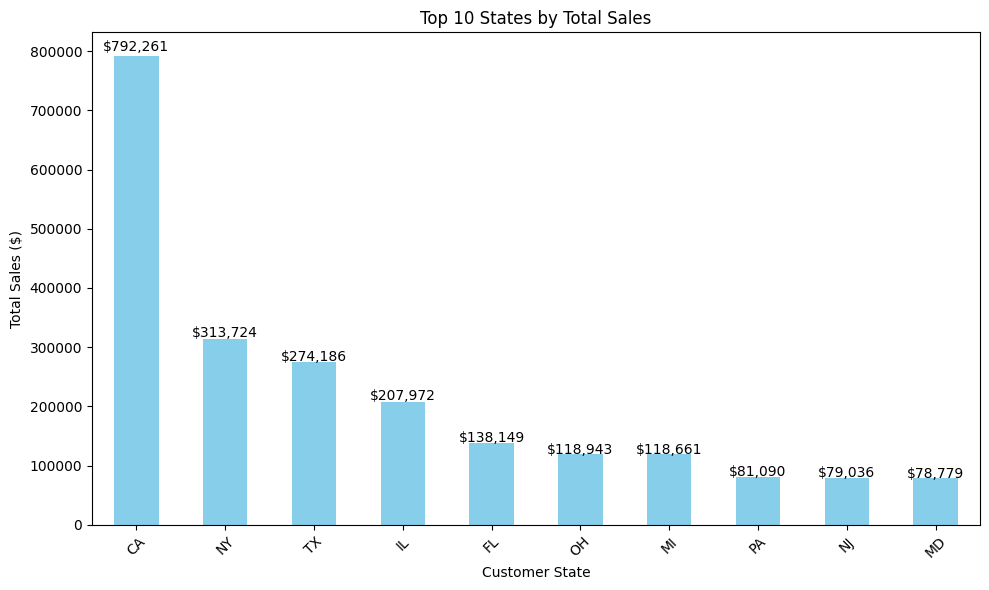

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
ax = top10.plot(kind='bar', color='skyblue', title='Top 10 States by Total Sales')

# Labeleed axes
plt.xlabel('Customer State')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)

# data labels on top of each bar
for i, value in enumerate(top10.values):
    ax.text(i, value + (value * 0.01), f"${value:,.0f}", ha='center')

plt.tight_layout()
plt.show()

In [ ]:
# Sales by Month
df.groupby(['order_month'])['sales'].sum().sort_values(ascending=False)

#verify order year and month
print(df['order_year'].unique(),df['order_month'].unique())

[2016] [5 4 8 7 6]


<Axes: title={'center': 'Monthly Sales Trend'}, xlabel='order_month'>

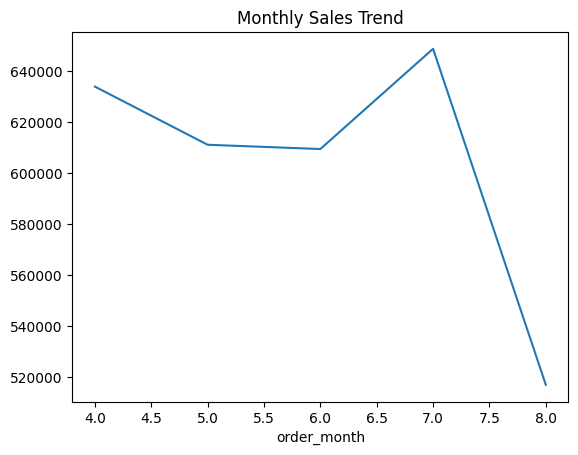

In [ ]:
# Plot of Sales by Month
df.groupby('order_month')['sales'].sum().plot(kind='line',title='Monthly Sales Trend')

# Are there outliers in the plot above ?

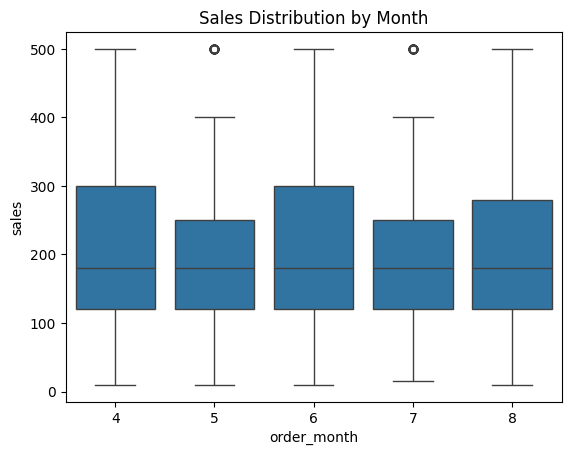

In [ ]:
# checking with a box plot
sns.boxplot(x=df['order_month'], y=df['sales'])
plt.title('Sales Distribution by Month')
plt.show()

In [ ]:
# this will apply the function to each column and filter for outliers
df_no_outliers = df.groupby('order_month', group_keys=False).apply(
    lambda g: g[
        (g['sales'] >= g['sales'].quantile(0.25) - 1.5 * (g['sales'].quantile(0.75) - g['sales'].quantile(0.25))) &
        (g['sales'] <= g['sales'].quantile(0.75) + 1.5 * (g['sales'].quantile(0.75) - g['sales'].quantile(0.25)))
    ]
)

<ipython-input-116-bf8909fc1270>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_no_outliers = df.groupby('order_month', group_keys=False).apply(


Text(0, 0.5, 'Sales ($)')

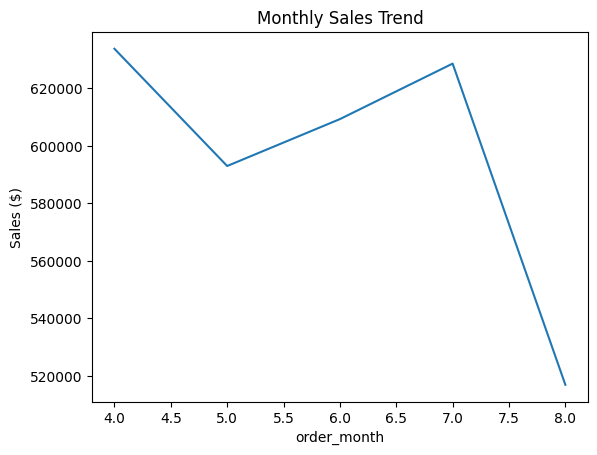

In [ ]:
# Sales by month/year
df_no_outliers.groupby(['order_month'])['sales'].sum().sort_values(ascending=False)
# Line plot over time
df_no_outliers.groupby('order_month')['sales'].sum().plot(kind='line',title='Monthly Sales Trend')
plt.ylabel('Sales ($)')

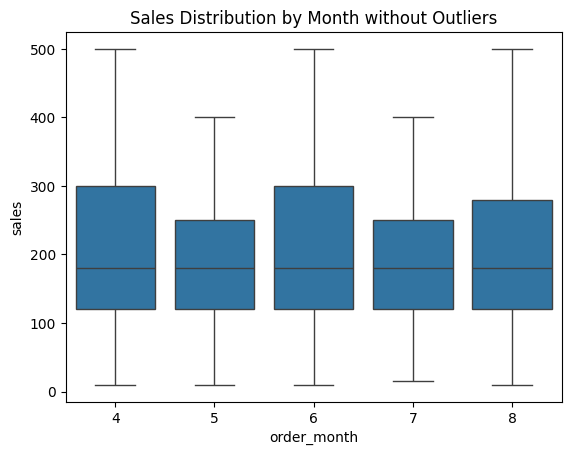

In [ ]:
sns.boxplot(x=df_no_outliers['order_month'], y=df_no_outliers['sales'])
plt.title('Sales Distribution by Month without Outliers')
plt.show()

Text(0.5, 0, 'Customer Segment')

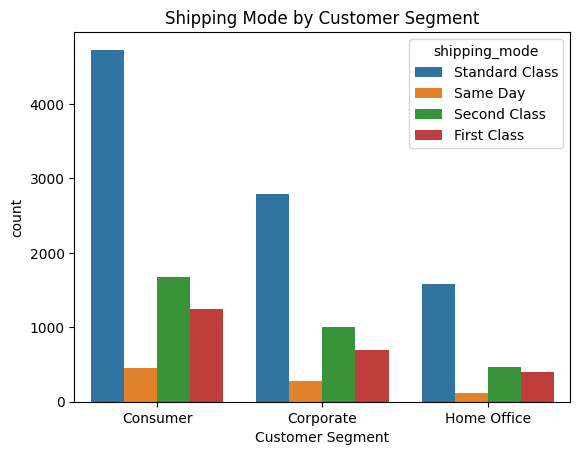

In [ ]:
# customer segment vs shipping mode
sns.countplot(data=df, x='customer_segment', hue='shipping_mode')
plt.title("Shipping Mode by Customer Segment")
plt.xlabel("Customer Segment")

Text(0.5, 0, 'Total Sales')

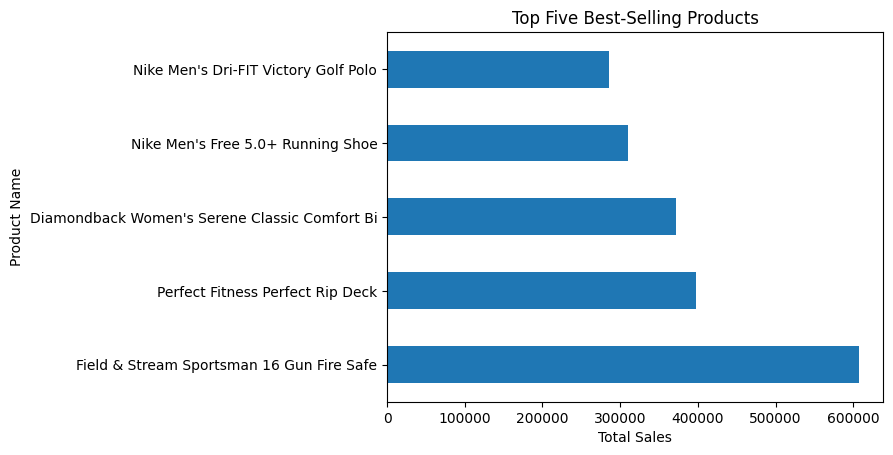

In [ ]:
# Top 5 best selling product
df.groupby('product_name')['sales'].sum().sort_values(ascending=False).head(5).plot(kind='barh', title='Top Five Best-Selling Products')
plt.ylabel('Product Name')
plt.xlabel('Total Sales')

<ipython-input-121-bdd06cd877cc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


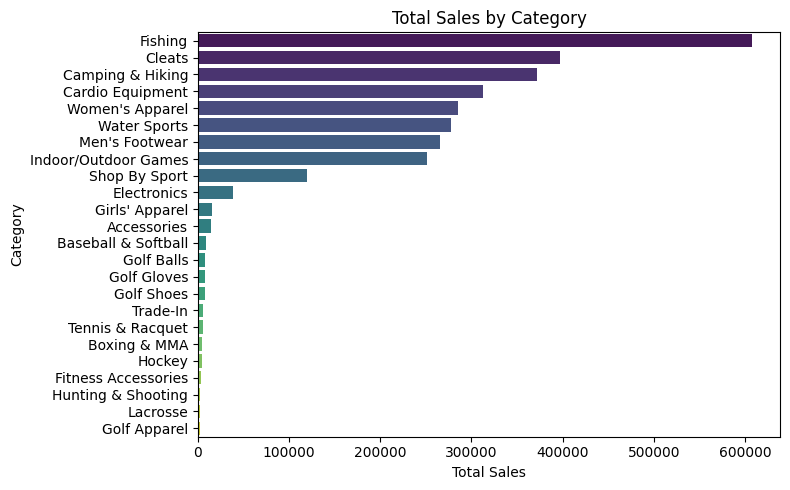

In [ ]:
# Sales by Category
cat_vals = df.groupby('category_name')['sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(
    x=cat_vals.values,
    y=cat_vals.index,
    orient='h',
    palette='viridis'
)
plt.title('Total Sales by Category')
plt.xlabel('Total Sales')
plt.ylabel('Category')
plt.tight_layout()
plt.show()



In [ ]:
# most popular products by state
most_popular_by_state = (
    df.groupby(['order_state', 'product_name'])['order_item_quantity']
    .sum()
    .reset_index()
    .sort_values('order_item_quantity', ascending=False)
    .loc[lambda d: d.groupby('order_state')['order_item_quantity'].idxmax()]
    .sort_values('order_item_quantity', ascending=False)
    [['order_state', 'product_name', 'order_item_quantity']]
)
most_popular_by_state.head(10)

,order_state,product_name,order_item_quantity
93,California,Perfect Fitness Perfect Rip Deck,1458
953,Texas,Perfect Fitness Perfect Rip Deck,706
703,Nueva York,Nike Men's Dri-FIT Victory Golf Polo,684
859,Pensilvania,O'Brien Men's Neoprene Life Vest,364
1066,Washington,Perfect Fitness Perfect Rip Deck,342
375,Illinois,Perfect Fitness Perfect Rip Deck,333
775,Ohio,Nike Men's Dri-FIT Victory Golf Polo,286
294,Florida,Perfect Fitness Perfect Rip Deck,267
26,Arizona,Perfect Fitness Perfect Rip Deck,160
141,Carolina del Norte,Perfect Fitness Perfect Rip Deck,157


Text(0, 0.5, 'Days Before Order Received')

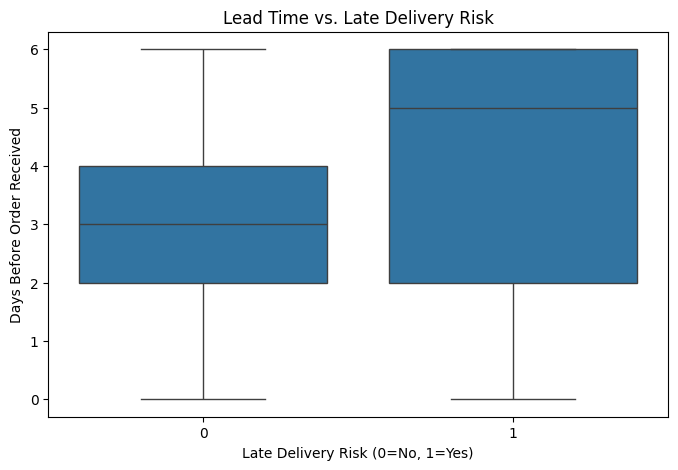

In [ ]:
# Do longer lead times correlate with higher late delivery probability?
# lead time is how long it takes before you get your order after placing it
plt.figure(figsize=(8,5))
sns.boxplot(
    x='late_delivery_risk',
    y='days_before_order_received',
    data=df,
)
plt.title('Lead Time vs. Late Delivery Risk')
plt.xlabel('Late Delivery Risk (0=No, 1=Yes)')
plt.ylabel('Days Before Order Received')


Text(0, 0.5, 'Order State')

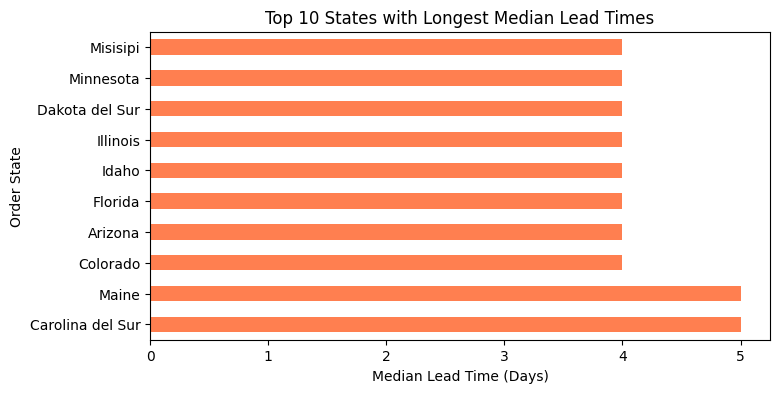

In [ ]:
# Top 10 states with longest median lead times
lead_time_by_state = df.groupby('order_state')['days_before_order_received'].median().sort_values(ascending=False)

plt.figure(figsize=(8,4))
lead_time_by_state.head(10).plot(kind='barh', color='coral')
plt.title('Top 10 States with Longest Median Lead Times')
plt.xlabel('Median Lead Time (Days)')
plt.ylabel('Order State')

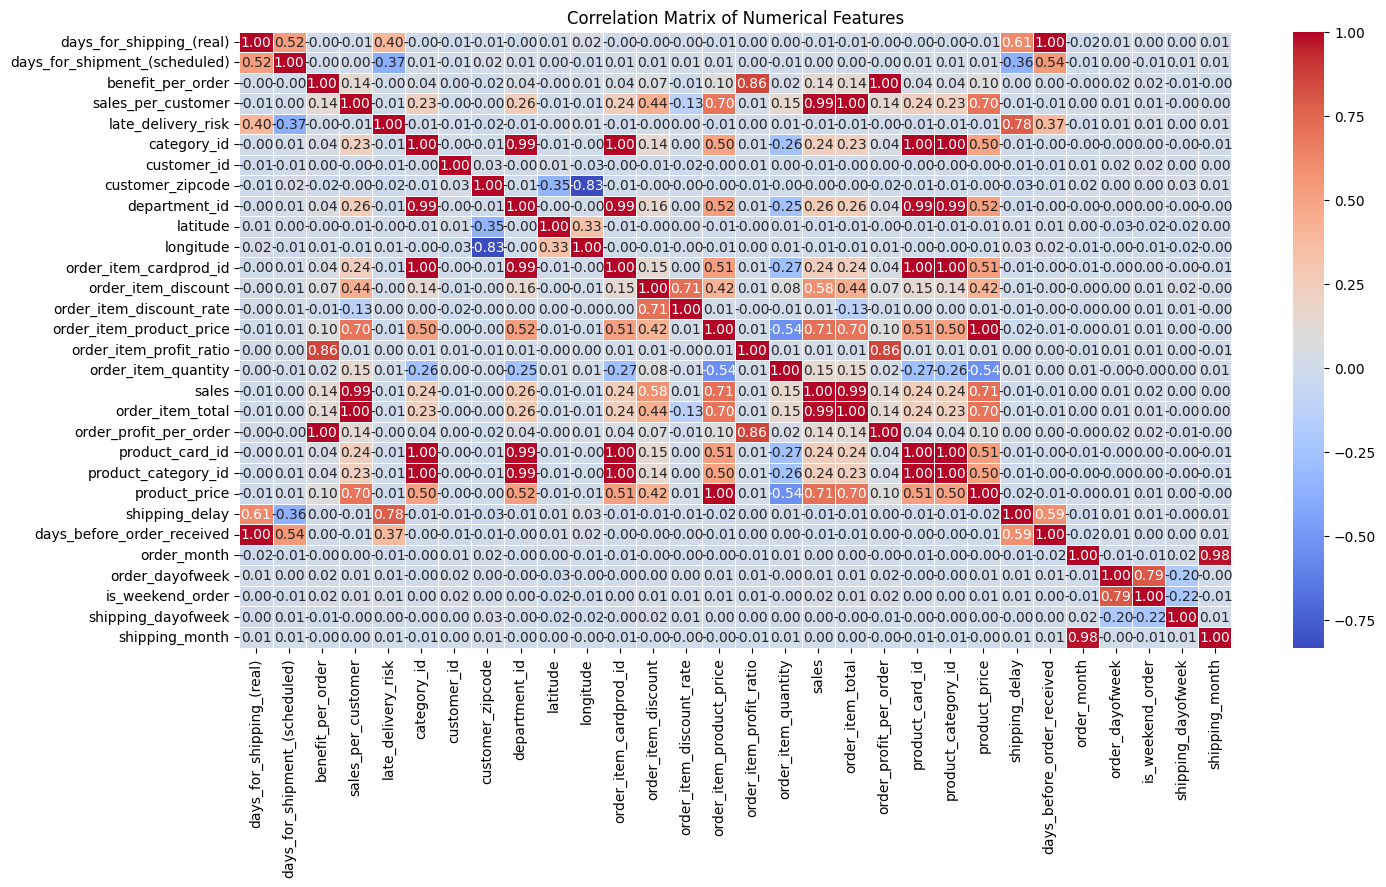

In [ ]:
# Calculate correlations for numeric columns
corr_matrix = df.select_dtypes(include=['int32','int64','float64']).drop(columns=['order_year']).corr()

plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [ ]:
# Numerical correlations with focus on the target variable(late_delivery_risk)
corr_breakdown = corr_matrix['late_delivery_risk'].sort_values(ascending=False)
print(corr_breakdown)

late_delivery_risk               1.000000
shipping_delay                   0.778183
days_for_shipping_(real)         0.396777
days_before_order_received       0.370240
longitude                        0.014684
is_weekend_order                 0.012946
order_item_quantity              0.006764
order_dayofweek                  0.005828
shipping_month                   0.005258
order_item_discount_rate         0.004415
shipping_dayofweek               0.003696
order_item_profit_ratio          0.001258
latitude                        -0.000183
order_item_discount             -0.000859
order_profit_per_order          -0.001272
benefit_per_order               -0.001272
sales                           -0.007725
order_item_total                -0.008326
sales_per_customer              -0.008326
customer_id                     -0.008581
order_month                     -0.009019
category_id                     -0.009408
product_category_id             -0.009408
product_card_id                 -0

In [ ]:
df.delivery_status.unique()

array(['Shipping canceled', 'Advance shipping', 'Late delivery',
       'Shipping on time'], dtype=object)

In [ ]:
df.columns

Index(['type', 'days_for_shipping_(real)', 'days_for_shipment_(scheduled)',
       'benefit_per_order', 'sales_per_customer', 'delivery_status',
       'late_delivery_risk', 'category_id', 'category_name', 'customer_city',
       'customer_country', 'customer_id', 'customer_segment', 'customer_state',
       'customer_zipcode', 'department_id', 'department_name', 'latitude',
       'longitude', 'order_city', 'order_country', 'order_date_(dateorders)',
       'order_item_cardprod_id', 'order_item_discount',
       'order_item_discount_rate', 'order_item_product_price',
       'order_item_profit_ratio', 'order_item_quantity', 'sales',
       'order_item_total', 'order_profit_per_order', 'order_region',
       'order_state', 'order_status', 'product_card_id', 'product_category_id',
       'product_name', 'product_price', 'shipping_date_(dateorders)',
       'shipping_mode', 'shipping_delay', 'days_before_order_received',
       'order_month', 'order_dayofweek', 'order_year', 'is_weekend_o

### Feature Engineering 2

In [ ]:
# drop unimportant columns using result from corr matrix
# late_delivery_risk as target variable

cols_to_drop = [
    # direct Identifiers (No Predictive Power / Risk of Overfitting)
    'customer_id',
    'order_item_cardprod_id',
    'product_card_id', 'customer_country','order_country',

    # these can cause data leakage and reveal the target variable (offers post-order information)
    'delivery_status',
    'shipping_delay', # this is only known after the order has been shipped
    'days_before_order_received','days_for_shipment_(scheduled)',

    # high cardinality features
    'product_name',
    'customer_city',
    'order_city', 'order_month',

    #  redundant and derivable features
    'order_item_total',               # r = -0.0061; derivable from price * quantity
    'sales',                          # r = -0.0067; redundant with order metrics
    'category_id',                    # r = -0.0070; keeping category_name instead
    'department_id',                  # r = -0.0091; keeping department_name instead
    'product_category_id',            # r = -0.0070; redundant
    'order_item_product_price',       # r = -0.0089; redundant to product_price
    'product_price',                  #  r = -0.0089; redundant
    'order_item_discount',            # r = -0.0012; weak correlation
    'order_item_discount_rate',       # r = 0.0035; weak correlation
    'benefit_per_order',              # r = 0.0002; weak correlation
    'order_profit_per_order',         # r = 0.0002; weak correlation
    'sales_per_customer',             # r = -0.0061; weak correlation

    # temporal features with low predictive power
    'order_date_(dateorders)',        # Raw timestamp; already extracted parts like month/day of week
    'shipping_date_(dateorders)',     # possible leakage risk
    'order_year',                     # Low variance; all the same year
    'latitude',                       # r = 0.0036; weak correlation
    'longitude',                      # r = 0.0099; weak correlation
    'customer_zipcode',              # r = -0.0184; noisy, high cardinality
    'is_weekend_order'               # r = 0.013; weak correlation
]

df = df.drop(columns=cols_to_drop, axis=1)

In [ ]:
# remaining features
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 15442 entries, 183 to 177551
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   type                      15442 non-null  object 
 1   days_for_shipping_(real)  15442 non-null  int64  
 2   late_delivery_risk        15442 non-null  int64  
 3   category_name             15442 non-null  object 
 4   customer_segment          15442 non-null  object 
 5   customer_state            15442 non-null  object 
 6   department_name           15442 non-null  object 
 7   order_item_profit_ratio   15442 non-null  float64
 8   order_item_quantity       15442 non-null  int64  
 9   order_region              15442 non-null  object 
 10  order_state               15442 non-null  object 
 11  order_status              15442 non-null  object 
 12  shipping_mode             15442 non-null  object 
 13  order_dayofweek           15442 non-null  int32  
 14  shipping

In [ ]:
df.shape

(15442, 16)

# ML Analysis

# Split dataset and begin Training

In [ ]:
X = df.drop(columns='late_delivery_risk', axis=1)
y = df['late_delivery_risk']

# Create a Train, Validation and Test set
X_bulk, X_test, y_bulk, y_test = train_test_split(X,y,test_size=0.2, random_state=22, stratify=y) # stratify y to maintain the same distribution of the target variable
X_train, X_val, y_train, y_val = train_test_split(X_bulk,y_bulk, test_size=0.25, random_state=22,stratify=y_bulk)

print(f"Train: {len(X_train)} ({len(X_train)/len(X):.1%})")
print(f"Val:   {len(X_val)} ({len(X_val)/len(X):.1%})")
print(f"Test:  {len(X_test)} ({len(X_test)/len(X):.1%})")

Train: 9264 (60.0%)
Val:   3089 (20.0%)
Test:  3089 (20.0%)


In [ ]:
# check class balance
y_train.value_counts(normalize=True) # both are roughly the same

,proportion
late_delivery_risk,
1,0.552461
0,0.447539


In [ ]:
# analyze cardinality in categorical columns to determine which encoder to use
for col in X_train.select_dtypes(include='object').columns:
    print(f"\nColumn: {col}")
    print(X_train[col].nunique())



Column: type
4

Column: category_name
24

Column: customer_segment
3

Column: customer_state
43

Column: department_name
6

Column: order_region
4

Column: order_state
48

Column: order_status
9

Column: shipping_mode
4


In [ ]:
# transform both numerical and categorical columns
num_cols = df.select_dtypes(include=['int32','int64','float64']).drop(columns='late_delivery_risk').columns

# Categorical columns and encoding type based on nunique() groups in each
onehot_cols = ['type', 'customer_segment', 'department_name', 'order_region']  # Low-cardinality
ordinal_cols = ['order_status', 'shipping_mode']  # these columns seem ordinal by nature (ex: completed order > payment review)
target_cols = ['category_name', 'customer_state', 'order_state']  # High-cardinality


# apply target encoding separately(since it requires y variable) to avoid data leakage
targ_encd = TargetEncoder()
X_train_te = targ_encd.fit_transform(X_train[target_cols],y_train)
X_val_te = targ_encd.transform(X_val[target_cols])
X_test_te = targ_encd.transform(X_test[target_cols])

## drop old features in X and join the encoded version
# convert to DataFrames with column names
X_train_te = pd.DataFrame(X_train_te, columns=target_cols, index=X_train.index)
X_val_te = pd.DataFrame(X_val_te, columns=target_cols, index=X_val.index)
X_test_te = pd.DataFrame(X_test_te, columns=target_cols, index=X_test.index)

# join
X_train_temp = X_train.drop(columns=target_cols).join(X_train_te)
X_val_temp = X_val.drop(columns=target_cols).join(X_val_te)
X_test_temp = X_test.drop(columns=target_cols).join(X_test_te)


# transfrom remaining categorical features
preprocessor = ColumnTransformer(
    transformers = [
    ('num',StandardScaler(),num_cols), # transforms all other numerical features besides the target variable
    ('one_hot',OneHotEncoder(drop='first', handle_unknown='ignore',sparse_output=False),onehot_cols),
    ('ordinal', OrdinalEncoder(), ordinal_cols)
],
    remainder = 'passthrough'
)

X_train_processed = preprocessor.fit_transform(X_train_temp)
X_val_processed = preprocessor.transform(X_val_temp)
X_test_processed = preprocessor.transform(X_test_temp)

# Dimensionality Reduction

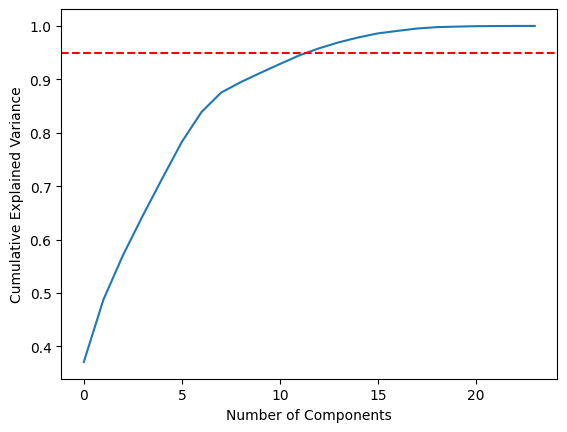

In [ ]:
# number of components that capture 95% variance in the dataset
pca_full = PCA().fit(X_train_processed)
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95,color='red',linestyle='dashed')

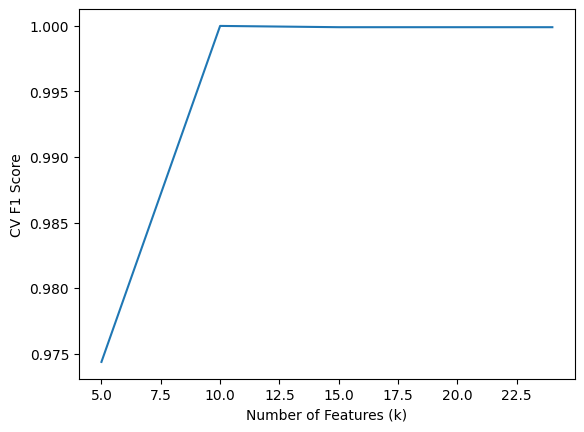

Optimal k: 10


In [ ]:
# find the optimal number of K
# test k values from 5 to 24
k_options = [5,10,15,24]
scores = []

for k in k_options:
    X_kbest = SelectKBest(f_classif, k=k).fit_transform(X_train_processed, y_train)
    score = cross_val_score(RandomForestClassifier(), X_kbest, y_train, cv=5, scoring='f1').mean()
    scores.append(score)

# Plot results
plt.plot(k_options, scores)
plt.xlabel('Number of Features (k)')
plt.ylabel('CV F1 Score')
plt.show()

# Select k with highest score
best_k = k_options[np.argmax(scores)]
print(f"Optimal k: {best_k}")

In [ ]:
pca = PCA(n_components=0.95, random_state=22) # approx 13 component capture 95% of the variance
X_train_pca = pca.fit_transform(X_train_processed) # unsupervised so y_train not used
X_val_pca = pca.transform(X_val_processed)
X_test_pca = pca.transform(X_test_processed)

# Get PCA result
print(f"Original features: {X_train_processed.shape[1]}")
print(f"PCA created {pca.n_components_} components")

# feature selection using SelectKBest
kbest = SelectKBest(score_func=f_classif, k=10) # selects top 10 features
X_train_kbest = kbest.fit_transform(X_train_processed, y_train)
X_val_kbest = kbest.transform(X_val_processed)
X_test_kbest = kbest.transform(X_test_processed)

# Get selected feature names
feature_names = preprocessor.get_feature_names_out()
selected_mask = kbest.get_support()
selected_features = feature_names[selected_mask]
print(f'\nKBest selected features:\n{selected_features}')


Original features: 24
PCA created 12 components

KBest selected features:
['num__days_for_shipping_(real)' 'num__order_item_quantity'
 'one_hot__type_DEBIT' 'one_hot__type_PAYMENT' 'one_hot__type_TRANSFER'
 'one_hot__customer_segment_Corporate' 'one_hot__department_name_Outdoors'
 'ordinal__shipping_mode' 'remainder__customer_state'
 'remainder__order_state']


# Model Training: logisticRegression, NB, KNN, Random Forest, SVM

In [ ]:
# initialize models
logreg = LogisticRegression(class_weight='balanced',random_state=22)
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=22)
svc = SVC(kernel='linear',class_weight='balanced',random_state=22, probability=True)


# function for model training
def ml_model(name,model,X_train, y_train, X_val, y_val):
  model.fit(X_train,y_train)
  y_val_pred = model.predict(X_val)

  print(f'\n=========={name}========== Results:\n')
  print('-' * 30)
  print('Accuracy:', accuracy_score(y_val,y_val_pred))
  print("Precision:", precision_score(y_val, y_val_pred))
  print("Recall:", recall_score(y_val, y_val_pred))
  print('F1-score:',f1_score(y_val,y_val_pred))
  print('\nClassification Report:\n')
  print(classification_report(y_val,y_val_pred))
  print('Confusiion Matrix:\n')
  print(confusion_matrix(y_val,y_val_pred))



# All Features: (X_train_processed, X_val_processed),
# PCA Features: (X_train_pca, X_val_pca),
# KBest Features: (X_train_kbest, X_val_kbest)


# evaluating on all features
print('           Report on ALL Features           ')
ml_model("Logistic Regression", logreg, X_train_processed, y_train, X_val_processed, y_val)
ml_model("Naive Bayes", nb, X_train_processed, y_train, X_val_processed, y_val)
ml_model("K-Nearest Neighbors", knn, X_train_processed, y_train, X_val_processed, y_val)
ml_model("Random Forest", rf, X_train_processed, y_train, X_val_processed, y_val)
ml_model("Support Vector Classifier",svc, X_train_processed, y_train, X_val_processed, y_val)


           Report on ALL Features           

==========Logistic Regression========== Results:

------------------------------
Accuracy: 0.9862869198312236
Precision: 0.9947089947089947
Recall: 0.9825783972125436
F1-score: 0.9886064855390009

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       374
           1       0.99      0.98      0.99       574

    accuracy                           0.99       948
   macro avg       0.98      0.99      0.99       948
weighted avg       0.99      0.99      0.99       948

Confusiion Matrix:

[[371   3]
 [ 10 564]]

==========Naive Bayes========== Results:

------------------------------
Accuracy: 0.8396624472573839
Precision: 0.827639751552795
Recall: 0.9285714285714286
F1-score: 0.8752052545155994

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.70      0.78       374
           1       0.83      0.93      0.

In [ ]:
# -------------------------------
# evaluating on PCA-reduced features
# -------------------------------

print('\n' + '='*50)
print('Evaluating models using PCA-reduced features')
print('='*50 + '\n')

ml_model("Logistic Regression (PCA)", logreg, X_train_pca, y_train, X_val_pca, y_val)
ml_model("Naive Bayes (PCA)", nb, X_train_pca, y_train, X_val_pca, y_val)
ml_model("K-Nearest Neighbors (PCA)", knn, X_train_pca, y_train, X_val_pca, y_val)
ml_model("Random Forest (PCA)", rf, X_train_pca, y_train, X_val_pca, y_val)
ml_model("Support Vector Classifier (PCA)", svc, X_train_pca, y_train, X_val_pca, y_val)


Evaluating models using PCA-reduced features


==========Logistic Regression (PCA)========== Results:

------------------------------
Accuracy: 0.9873417721518988
Precision: 0.9929824561403509
Recall: 0.9860627177700348
F1-score: 0.9895104895104895

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       374
           1       0.99      0.99      0.99       574

    accuracy                           0.99       948
   macro avg       0.99      0.99      0.99       948
weighted avg       0.99      0.99      0.99       948

Confusiion Matrix:

[[370   4]
 [  8 566]]

==========Naive Bayes (PCA)========== Results:

------------------------------
Accuracy: 0.9324894514767933
Precision: 0.9903846153846154
Recall: 0.8972125435540069
F1-score: 0.9414990859232175

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       374
           1       0.99   

In [ ]:
# -------------------------------
# Evaluating on SelectKBest features
# -------------------------------

print('\n' + '='*50)
print('Evaluating models using SelectKBest features')
print('='*50 + '\n')

ml_model("Logistic Regression (KBest)", logreg, X_train_kbest, y_train, X_val_kbest, y_val)
ml_model("Naive Bayes (KBest)", nb, X_train_kbest, y_train, X_val_kbest, y_val)
ml_model("K-Nearest Neighbors (KBest)", knn, X_train_kbest, y_train, X_val_kbest, y_val)
ml_model("Random Forest (KBest)", rf, X_train_kbest, y_train, X_val_kbest, y_val)
ml_model("Support Vector Classifier (KBest)", svc, X_train_kbest, y_train, X_val_kbest, y_val)


Evaluating models using SelectKBest features


==========Logistic Regression (KBest)========== Results:

------------------------------
Accuracy: 0.9852320675105485
Precision: 0.9964539007092199
Recall: 0.9790940766550522
F1-score: 0.9876977152899824

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       374
           1       1.00      0.98      0.99       574

    accuracy                           0.99       948
   macro avg       0.98      0.99      0.98       948
weighted avg       0.99      0.99      0.99       948

Confusiion Matrix:

[[372   2]
 [ 12 562]]

==========Naive Bayes (KBest)========== Results:

------------------------------
Accuracy: 0.8565400843881856
Precision: 0.8476190476190476
Recall: 0.9303135888501742
F1-score: 0.8870431893687708

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.74      0.80       374
           1       0.8

In [ ]:
# for baseline features(all 24 features), SVC is the best with an F1-score of 0.98
# for PCA features,  SVC was also the best classifier with an F1-score of 0.98
# for SelectKBest features, KNN was the best classifier wiht an F1-score of 0.99


# will use KNN since it had the highest f1 and recall score

# KNN model tuning

In [ ]:
# Define parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7], # earlier i used the default n= 5 neighbors
    'metric': ['euclidean', 'manhattan']  # defines how the distance between two points will be calculated
}

# Initialize GridSearchCV with KNN and 5-fold CV
grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,  # Cross-validation on training data
    scoring='f1'  # Optimize for F1-score
)

# Fit the new model on training data (X_train_kbest, y_train)
grid.fit(X_train_kbest, y_train)

# Check for best parameters
print("Best Hyperparameters:", grid.best_params_)

Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 5}


# Find out if tuning improved performance

In [ ]:
# Evaluate tuned model on the validation set (X_val_kbest, y_val)
y_val_pred_tuned = grid.predict(X_val_kbest)
print("\nTuned KNN (Validation):")
print('F1-score:',f1_score(y_val,y_val_pred_tuned),'\n')
print('Accuracy:', accuracy_score(y_val,y_val_pred_tuned))
print("Precision:", precision_score(y_val, y_val_pred_tuned))
print("Recall:", recall_score(y_val, y_val_pred_tuned))
print(classification_report(y_val, y_val_pred_tuned, digits=4))


Tuned KNN (Validation):
F1-score: 0.9878260869565217 

Accuracy: 0.9852320675105485
Precision: 0.9861111111111112
Recall: 0.9895470383275261
              precision    recall  f1-score   support

           0     0.9839    0.9786    0.9812       374
           1     0.9861    0.9895    0.9878       574

    accuracy                         0.9852       948
   macro avg     0.9850    0.9841    0.9845       948
weighted avg     0.9852    0.9852    0.9852       948



# Compare the tuned and original KNN model on the test dataset

In [ ]:
# Use the best estimator from GridSearchCV
tuned_knn = grid.best_estimator_  # this is from the trained model, so it uses {'metric': 'manhattan', 'n_neighbors': 5}
# validate that it's the same
print("Best model hyperparameters:", tuned_knn.get_params())

# Evaluate tuned model on TEST set
print("\n=== Tuned KNN (Test Set) ===")
y_test_pred_tuned = tuned_knn.predict(X_test_kbest)
print("F1-score",f1_score(y_test,y_test_pred_tuned),'\n')
print(classification_report(y_test, y_test_pred_tuned, digits=4))

# Compare to default model/ original KNN model
print("\n=== Original KNN (Test Set) ===")
default_knn = KNeighborsClassifier().fit(X_train_kbest, y_train)  # Euclidean, n_neighbors=5
y_test_pred_default = default_knn.predict(X_test_kbest)
print("F1-score",f1_score(y_test,y_test_pred_default),'\n')
print(classification_report(y_test, y_test_pred_default, digits=4))


# Near-identical performance on validation and test sets between both models show
# there is no overfitting

Best model hyperparameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

=== Tuned KNN (Test Set) ===
F1-score 0.9844559585492227 

              precision    recall  f1-score   support

           0     0.9890    0.9626    0.9756       374
           1     0.9760    0.9930    0.9845       574

    accuracy                         0.9810       948
   macro avg     0.9825    0.9778    0.9800       948
weighted avg     0.9811    0.9810    0.9810       948


=== Original KNN (Test Set) ===
F1-score 0.9759036144578314 

              precision    recall  f1-score   support

           0     0.9806    0.9439    0.9619       374
           1     0.9643    0.9878    0.9759       574

    accuracy                         0.9705       948
   macro avg     0.9724    0.9658    0.9689       948
weighted avg     0.9707    0.9705    0.9704       948



# Names of Model Predictors

In [ ]:
# Get selected feature names
feature_names = preprocessor.get_feature_names_out()
selected_mask = kbest.get_support()
selected_features = feature_names[selected_mask]
print(f'\nKBest selected features:\n{selected_features}')


KBest selected features:
['num__days_for_shipping_(real)' 'num__order_item_quantity'
 'one_hot__type_DEBIT' 'one_hot__type_PAYMENT' 'one_hot__type_TRANSFER'
 'one_hot__customer_segment_Corporate' 'one_hot__department_name_Outdoors'
 'ordinal__shipping_mode' 'remainder__customer_state'
 'remainder__order_state']
